# Fairface Analysis
---

## Project Stages
This notebook serves as an implementation for the research discussed in the paper "Detecting and Analyzing Biases in Age Estimation Models: A Comprehensive Evaluation of Datasets and their biases" by Noah Wijnheijmer. This document will serve as a comprehensive implementation of the full analysis of one of the discussed datasets. As described in the afromentioned paper, the following workflow will be used:
 
The document will follow Google's PACE workflow:

- Plan(according to 'Datasheets for Datasets' )
- Analyze
- Construct
- Execute

supporting papers: 
https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf 

---
## 1. Plan

### 1.1 Frame the business scenario and problem

Using the methodology highlighed in the supporting paper, the following information has been carefully gathered on the dataset for dataset documentation with regards to Bias analysis:

<details>
<summary>Motivation</summary>
The UTKFace dataset was created to provide a large-scale face dataset with a wide age span for various facial analysis tasks1. The motivation appears to be supporting research in areas like face detection, age estimation, age progression/regression, and landmark localization.


</details>
<details>
<summary>Composition</summary>

- Over 20,000 face images
- Age annotations ranging from 0 to 116 years old
- Gender annotations (male/female)
- Ethnicity annotations (White, Black, Asian, Indian, Others)
- Images with variations in pose, facial expression, illumination, and occlusion

</details>

<details>
<summary>Collection Process</summary>

Images were collected from the internet, specific sources are however unknown (general webscrape)

</details>

<details>
<summary>Preprocessing/Cleaning/Labeling</summary>

- Images were aligned and cropped
- Facial landmarks (68 points) were extracted
- Age, gender, and ethnicity labels were estimated using the DEX algorithm and verified by human annotators

</details>

<details>
<summary>Uses</summary>

Intended uses of the dataset include:
- Face detection
- Age estimation
- Age progression/regression
- Landmark localization
- Gender and ethnicity classification

</details>

<details>
<summary>Distribution</summary>

The dataset is available for non-commercial research purposes and is distributed in various formats:
- In-the-wild faces (1.3GB ZIP file)
- Aligned and cropped faces (107MB ZIP file)
- Landmarks (12MB TXT file)

</details>

<details>
<summary>Maintenance</summary>

The dataset is maintained by the AICIP (Advanced Imaging and Collaborative Information Processing) lab. Contact information for inquiries includes Yang Song or Zhifei Zhang.

</details>


### 1.2 The Dataset

In [10]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
# Load the dataset
dataset = load_dataset("HuggingFaceM4/FairFace", "0.25")

# Convert the dataset to pandas DataFrames
train_df = dataset['train'].to_pandas()
train_df, validation_df = train_test_split(train_df, test_size=0.15, random_state=42)

test_df = dataset['validation'].to_pandas()

### 1.3 Imports


In [11]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate,
)
from matplotlib_venn import venn2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns
import plotly.express as px
import io
from PIL import Image



### 1.4 EDA


1. Age distribution
2. Gender distribution
3. Ethnic distribution
4. Completeness of annotations
5. ~~Validating~~
6. ~~Presenting~~

## Preprocessing
I didn't manually split the data, the retrieved data has 86.7k rows for the train set and 11k rows for validation

In [12]:
#gender and race dictionary
gender_dict = {0:"Male",1:"Female"}
age_dict = {0:"0-2",1:"3-9",2:"10-19",3:"20-29",4:"30-39",5:"40-49",6:"50-59",7:"60-69",8:"over 70"}
race_dict = {0:"East Asian",1:"Indian",2:"Black",3:"White",4:"Middle Eastern", 5:"Latino Hispanic", 6:"Southeast Asian"}

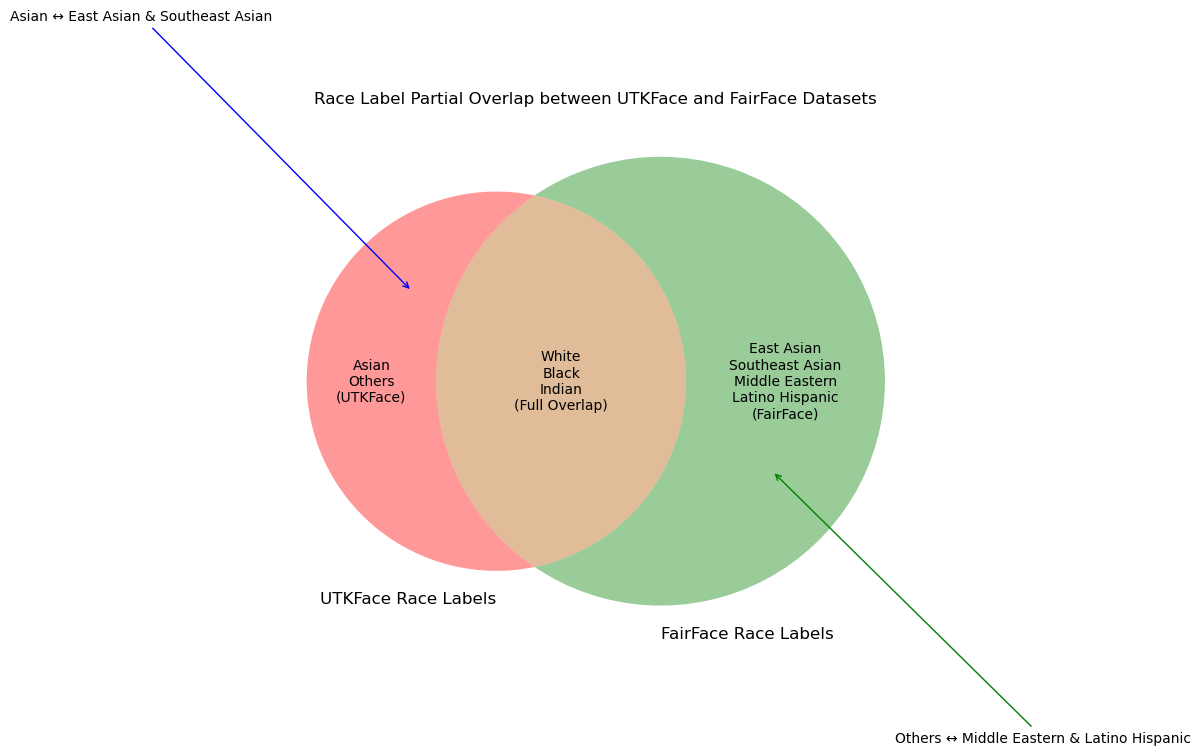

In [13]:
# Define race categories for each dataset
utkface_race_labels = {"White", "Black", "Asian", "Indian", "Others"}
fairface_race_labels = {"White", "Black", "East Asian", "Indian", "Middle Eastern", "Latino Hispanic", "Southeast Asian"}

plt.figure(figsize=(10, 7))
venn = venn2([utkface_race_labels, fairface_race_labels], set_labels=("UTKFace Race Labels", "FairFace Race Labels"))

# Full Overlap Section (11): White, Black, Indian
venn.get_label_by_id('11').set_text('White\nBlack\nIndian\n(Full Overlap)')

# UTKFace Unique (Asian and Others - partial overlaps explained below)
venn.get_label_by_id('10').set_text('Asian\nOthers\n(UTKFace)')

# FairFace Unique (East Asian, Southeast Asian, Middle Eastern, Latino Hispanic)
venn.get_label_by_id('01').set_text('East Asian\nSoutheast Asian\nMiddle Eastern\nLatino Hispanic\n(FairFace)')

# Annotate partial overlaps
plt.annotate("Asian ↔ East Asian & Southeast Asian", xy=(-0.4, 0.2), xytext=(-1, 0.8),
             ha='center', arrowprops=dict(arrowstyle="->", color='blue'))
plt.annotate("Others ↔ Middle Eastern & Latino Hispanic", xy=(0.4, -0.2), xytext=(1, -0.8),
             ha='center', arrowprops=dict(arrowstyle="->", color='green'))

# Title and show plot
plt.title("Race Label Partial Overlap between UTKFace and FairFace Datasets")
plt.show()
# Save plot
# plt.savefig("race_label_overlap.png", dpi=300)  # Save the figure


---
## 2. Analyze

Main goal of EDA in the analyze stage is to understand the relationships between variables and visualizations are integral in this section

**`Variables of interest should be identified at the start of this stage`**

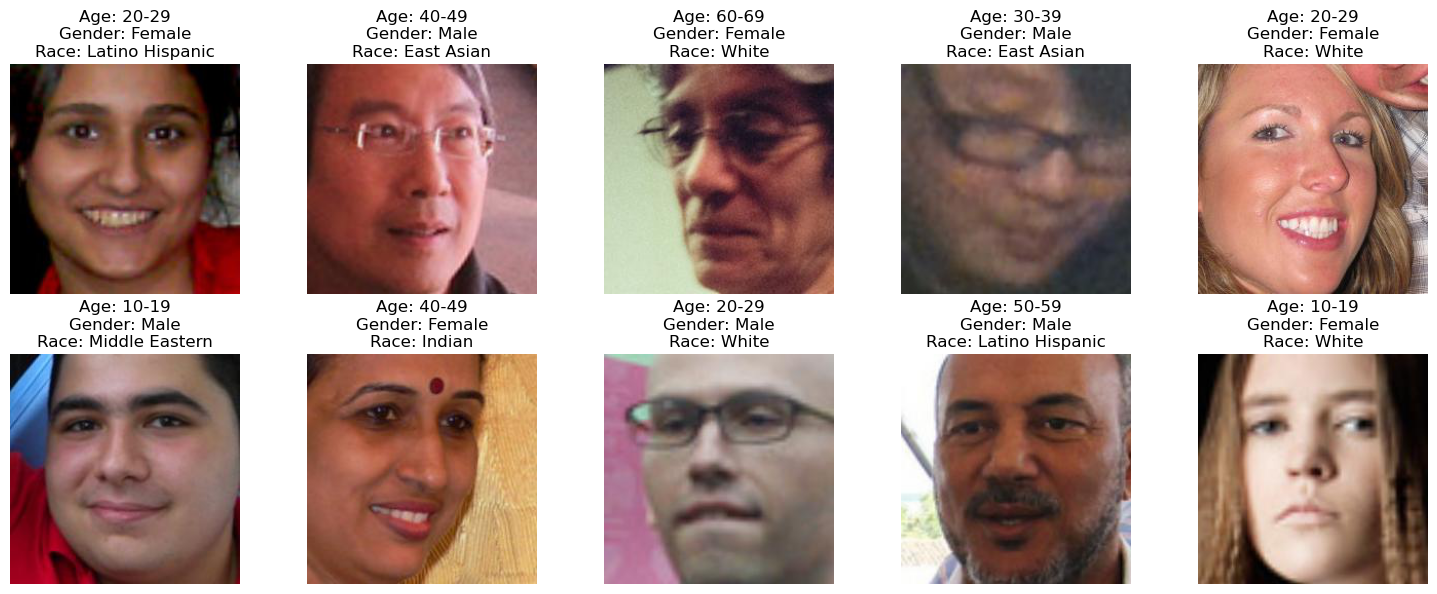

In [14]:
# Function to decode image bytes
def decode_image(image_bytes):
    return Image.open(io.BytesIO(image_bytes))

# Select random samples
num_samples = 10
random_indices = np.random.choice(train_df.index, num_samples, replace=False)
sample_images = train_df.loc[random_indices, 'image']
sample_ages = train_df.loc[random_indices, 'age']
sample_genders = train_df.loc[random_indices, 'gender']
sample_races = train_df.loc[random_indices, 'race']

# Plot the images in a grid
num_cols = 5
num_rows = num_samples // num_cols + (num_samples % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_samples:
        image_bytes = sample_images.iloc[i]['bytes']
        image = decode_image(image_bytes)
        ax.imshow(image)
        ax.axis('off')
        age_label = age_dict[sample_ages.iloc[i]]
        gender_label = gender_dict[sample_genders.iloc[i]]
        race_label = race_dict[sample_races.iloc[i]]
        ax.set_title(f"Age: {age_label}\nGender: {gender_label}\nRace: {race_label}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
plt.show()

#### gender distribution

In [15]:
# Counting the genders
gender_counts = Counter(train_df['gender'])
gender_counts

male_count = gender_counts[0]
female_count = gender_counts[1]

# Visualization of gender imbalance
gender_mapping = ['Male', 'Female']
pie_chart = px.pie(
    names=gender_mapping,
    values=[male_count, female_count],
    hole=0.4,
    title="Gender Distribution (Donut Chart)",
    height=500
)
pie_chart.show()


bar_graph = px.bar(
    y=gender_mapping,
    x=[male_count, female_count],
    title="Gender Distribution (Bar Graph)",
    color=gender_mapping,
    height=500
)
bar_graph.update_layout(
    yaxis_title="Gender",
    xaxis_title="Frequency Count"
)
bar_graph.show()


#### Age distribution

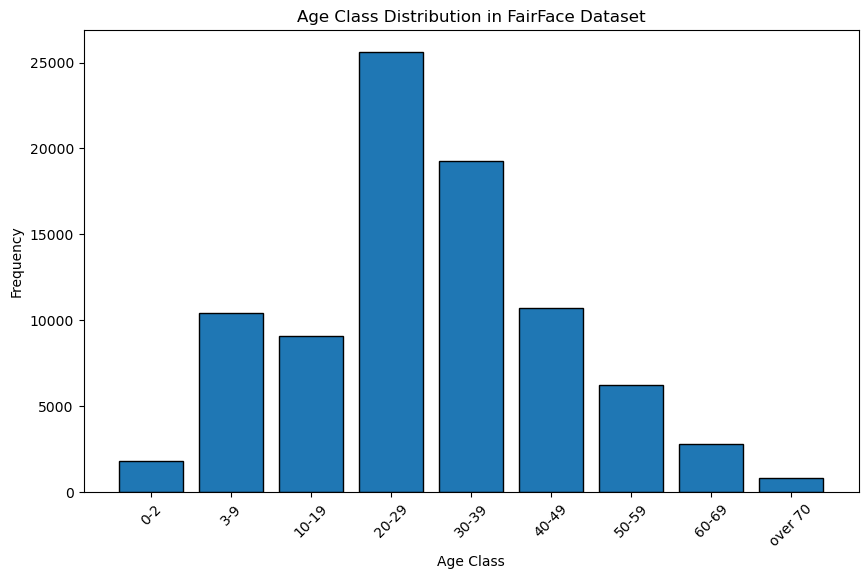

In [16]:
# Extract ages from the dataset and map them to age classes
age_classes = [age_dict[example['age']] for example in dataset['train']]

# Count the frequency of each age class
age_class_counts = Counter(age_classes)

# Sort the age classes by their order in age_dict
sorted_age_classes = sorted(age_class_counts.keys(), key=lambda x: list(age_dict.values()).index(x))

# Plot the age class distribution
plt.figure(figsize=(10, 6))
plt.bar(sorted_age_classes, [age_class_counts[age_class] for age_class in sorted_age_classes], edgecolor='black')
plt.title('Age Class Distribution in FairFace Dataset')
plt.xlabel('Age Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# The dataset seems to have a slight bias towards the ages between 20-29

In [17]:

# Calculate the total number of instances
total_count = len(age_classes)

# Calculate the percentage of each age class
age_class_percentages = {age_class: (count / total_count) * 100 for age_class, count in age_class_counts.items()}

# Print the percentage of each age class
for age_class, percentage in age_class_percentages.items():
    print(f"Percentage of records in age class {age_class}: {percentage:.2f}%")

Percentage of records in age class 50-59: 7.18%
Percentage of records in age class 30-39: 22.19%
Percentage of records in age class 3-9: 12.00%
Percentage of records in age class 20-29: 29.51%
Percentage of records in age class 40-49: 12.39%
Percentage of records in age class 10-19: 10.49%
Percentage of records in age class 60-69: 3.20%
Percentage of records in age class 0-2: 2.07%
Percentage of records in age class over 70: 0.97%


## Race

In [9]:
# Convert one-hot encoded races back to labels if necessary
if train_df['race'].ndim > 1:
    train_df['race'] = np.argmax(train_df['race'].values, axis=1)

race_counts = Counter(train_df['race'])

# Print the counts
for race, count in race_counts.items():
    print(f"Number of {race_dict[race]}: {count}")

# Visualization of race distribution
race_mapping = [race_dict[i] for i in range(len(race_dict))]
race_values = [race_counts[i] for i in range(len(race_dict))]

# Pie chart
pie_chart = px.pie(
    names=race_mapping,
    values=race_values,
    hole=0.4,
    title="Race Distribution of FairFace dataset",
    height=500
)
pie_chart.show()

Number of East Asian: 12287
Number of Indian: 12319
Number of Black: 12233
Number of White: 16527
Number of Middle Eastern: 9216
Number of Latino Hispanic: 13367
Number of Southeast Asian: 10795


The races are spread out very equally

#### 2.3 Insights

(Summarize insights from the analysis that has been done thus far)

---
## 3. Construct

With the aid of the Fairlearn library the following fairness metricswill be used :
• Demographic Parity: This metric will help measure
whether the age estimation model’s predictions are in-
dependent of other personal attributes like gender and
ethnicity.
• Equalized Odds: This metric will evaluate whether the
model’s true positive and false positive rates are similar
across different demographic groups.
• Disparate Impact: This metric measures fairness by com-
paring the ratio of positive outcomes between different
demographic groups, with a ratio close to 1.0 indicating
fair treatment.

### Import required Libraries

### Additional preprocessing

In [10]:
train_images = np.array([np.array(Image.open(io.BytesIO(img['bytes'])).resize((128, 128))) for img in train_df['image']])
train_ages = to_categorical(train_df['age'])

# Preprocess the validation images and gender labels
val_images = np.array([np.array(Image.open(io.BytesIO(img['bytes'])).resize((128, 128))) for img in validation_df['image']])
val_ages = to_categorical(validation_df['age'])


### Load the ResNet - 50 model

In [11]:
from tensorflow.keras.regularizers import l2

# I load the ResNet-50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)


predictions = Dense(train_ages.shape[1], activation='softmax')(x) 

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

2024-11-03 19:58:16.154939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44009 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Model compiling

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [13]:
# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,verbose=1)
#Fit model
history = model.fit(
    train_images, train_ages,
    epochs=8,
    validation_data=(val_images, val_ages),
    callbacks= [early_stopping],
)

Epoch 1/8


I0000 00:00:1730660308.250538  700157 service.cc:146] XLA service 0x7f26b0012f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730660308.250575  700157 service.cc:154]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-11-03 19:58:28.451304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 19:58:29.246861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-03 19:58:30.575717: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility package

   8/2711 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.1677 - loss: 18.4498 

I0000 00:00:1730660311.150256  700157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2711/2711 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.3653 - loss: 3.2477 - val_accuracy: 0.3910 - val_loss: 1.5511
Epoch 2/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.4018 - loss: 1.5216 - val_accuracy: 0.4062 - val_loss: 1.5133
Epoch 3/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.4091 - loss: 1.5027 - val_accuracy: 0.4089 - val_loss: 1.4969
Epoch 4/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.4080 - loss: 1.4886 - val_accuracy: 0.4082 - val_loss: 1.4737
Epoch 5/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.4087 - loss: 1.4855 - val_accuracy: 0.4028 - val_loss: 1.5112
Epoch 6/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.4081 - loss: 1.4871 - val_accuracy: 0.4125 - val_loss: 1.4866
Epoch 7/8
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.4121 - loss: 1.4784 - val_accuracy: 0.4008 - val_loss: 1.4989
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


### Model Evaluation

In [14]:
val_loss, val_accuracy = model.evaluate(val_images, val_ages)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4143 - loss: 1.4686
Validation Loss: 1.4736701250076294
Validation Accuracy: 0.4081614017486572


Model Performance: The model performs well overall with an accuracy of approximately 80% on the validation set.

### Plotting Training History

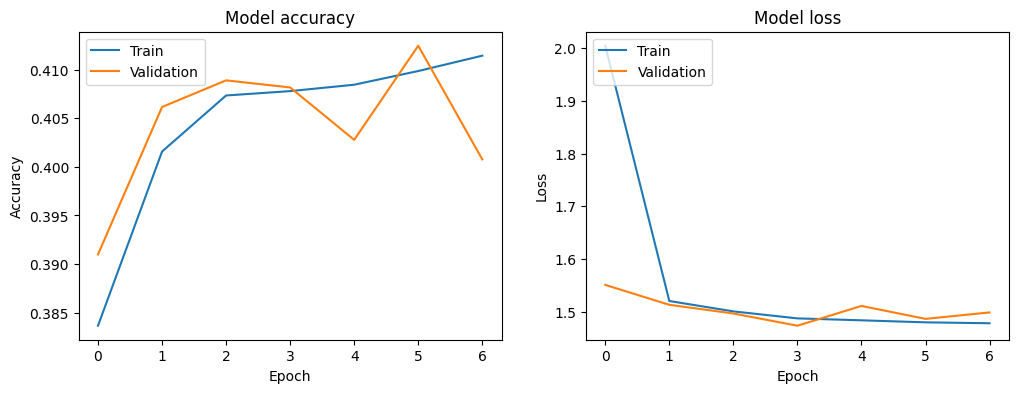

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The model is learning but overfitting, since the validation set is plaeauing and even seems to decrease at the end of the graph. When looking at the model loss, the validation data is increasing.
This means it's performing well on the training data but struggling to generalize to new data. To address this, i will try regularization, early stopping, and some hyperparameter tuning.

### Fairness Evaluation on Race

In [24]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# For each class, calculate metrics
num_classes = 7
demographic_parity_list = []
equalized_odds_list = []

for class_label in range(num_classes):
    binary_true_labels = (val_true_labels == class_label).astype(int)
    binary_pred_labels = (val_pred_labels == class_label).astype(int)
    
    demographic_parity = demographic_parity_difference(
        y_true=binary_true_labels, 
        y_pred=binary_pred_labels, 
        sensitive_features=sensitive_feature
    )
    equalized_odds = equalized_odds_difference(
        y_true=binary_true_labels, 
        y_pred=binary_pred_labels, 
        sensitive_features=sensitive_feature
    )
    
    demographic_parity_list.append(demographic_parity)
    equalized_odds_list.append(equalized_odds)

# Print the results for each class
for i in range(num_classes):
    print(f'Class {i}: Demographic Parity Difference: {demographic_parity_list[i]}, Equalized Odds Difference: {equalized_odds_list[i]}')


Class 0: Demographic Parity Difference: 0.012829271797417423, Equalized Odds Difference: 0.018374558303886925
Class 1: Demographic Parity Difference: 0.1331071147781509, Equalized Odds Difference: 0.20424028268551236
Class 2: Demographic Parity Difference: 0.005806451612903226, Equalized Odds Difference: 0.005806451612903226
Class 3: Demographic Parity Difference: 0.17962434696077623, Equalized Odds Difference: 0.5825806451612904
Class 4: Demographic Parity Difference: 0.15379652605459057, Equalized Odds Difference: 0.3002481389578164
Class 5: Demographic Parity Difference: 0.017783291976840365, Equalized Odds Difference: 0.03391232423490488
Class 6: Demographic Parity Difference: 0.07452440033085195, Equalized Odds Difference: 0.11000827129859388


# Interpretation of Fairness Metrics by Race Class

The results of the demographic parity and equalized odds differences for the various racial classes are presented below. These metrics provide insight into the fairness of the model's predictions across different race categories.

| Class | Race                   | Demographic Parity Difference | Equalized Odds Difference |
|-------|------------------------|-------------------------------|---------------------------|
| 0     | East Asian             | 0.0128                        | 0.0184                    |
| 1     | Indian                 | 0.1331                        | 0.2042                    |
| 2     | Black                  | 0.0058                        | 0.0058                    |
| 3     | White                  | 0.1796                        | 0.5826                    |
| 4     | Middle Eastern         | 0.1538                        | 0.3002                    |
| 5     | Latino Hispanic        | 0.0178                        | 0.0339                    |
| 6     | Southeast Asian        | 0.0745                        | 0.1100                    |

## Class Analysis

1. **East Asian (Class 0)**:
   - **Demographic Parity Difference (0.0128)**: This indicates a minor disparity in prediction rates between sensitive groups.
   - **Equalized Odds Difference (0.0184)**: The small value suggests similar true positive rates across groups.

2. **Indian (Class 1)**:
   - **Demographic Parity Difference (0.1331)**: There is a significant disparity, indicating that predictions for this group are less favorable compared to others.
   - **Equalized Odds Difference (0.2042)**: This reflects a substantial difference in true positive rates, suggesting that the model is less accurate for this group.

3. **Black (Class 2)**:
   - **Demographic Parity Difference (0.0058)**: This very low value suggests a fair treatment in prediction rates.
   - **Equalized Odds Difference (0.0058)**: Similar to demographic parity, indicating equitable true positive rates.

4. **White (Class 3)**:
   - **Demographic Parity Difference (0.1796)**: There is a notable disparity, suggesting that the model favors this group significantly in predictions.
   - **Equalized Odds Difference (0.5826)**: The high value indicates a substantial difference in accuracy between this group and others, pointing to potential bias.

5. **Middle Eastern (Class 4)**:
   - **Demographic Parity Difference (0.1538)**: This suggests a significant prediction disparity favoring other groups over this one.
   - **Equalized Odds Difference (0.3002)**: This indicates a moderate difference in prediction accuracy.

6. **Latino Hispanic (Class 5)**:
   - **Demographic Parity Difference (0.0178)**: The small value suggests a relatively fair prediction rate.
   - **Equalized Odds Difference (0.0339)**: Indicates slight differences in accuracy, but generally favorable.

7. **Southeast Asian (Class 6)**:
   - **Demographic Parity Difference (0.0745)**: A moderate disparity is present, indicating a need for improved fairness.
   - **Equalized Odds Difference (0.1100)**: This reflects some differences in accuracy, suggesting the model may need adjustments for this group.

## Summary

Overall, the model exhibits notable disparities in the predictions for certain racial groups, particularly the Indian and White classes, which show significant differences in both demographic parity and equalized odds. On the other hand, groups like Black and East Asian appear to have more equitable treatment in terms of prediction rates. The findings highlight the necessity for further investigation and potential recalibration of the model to reduce bias and enhance fairness across all racial categories.


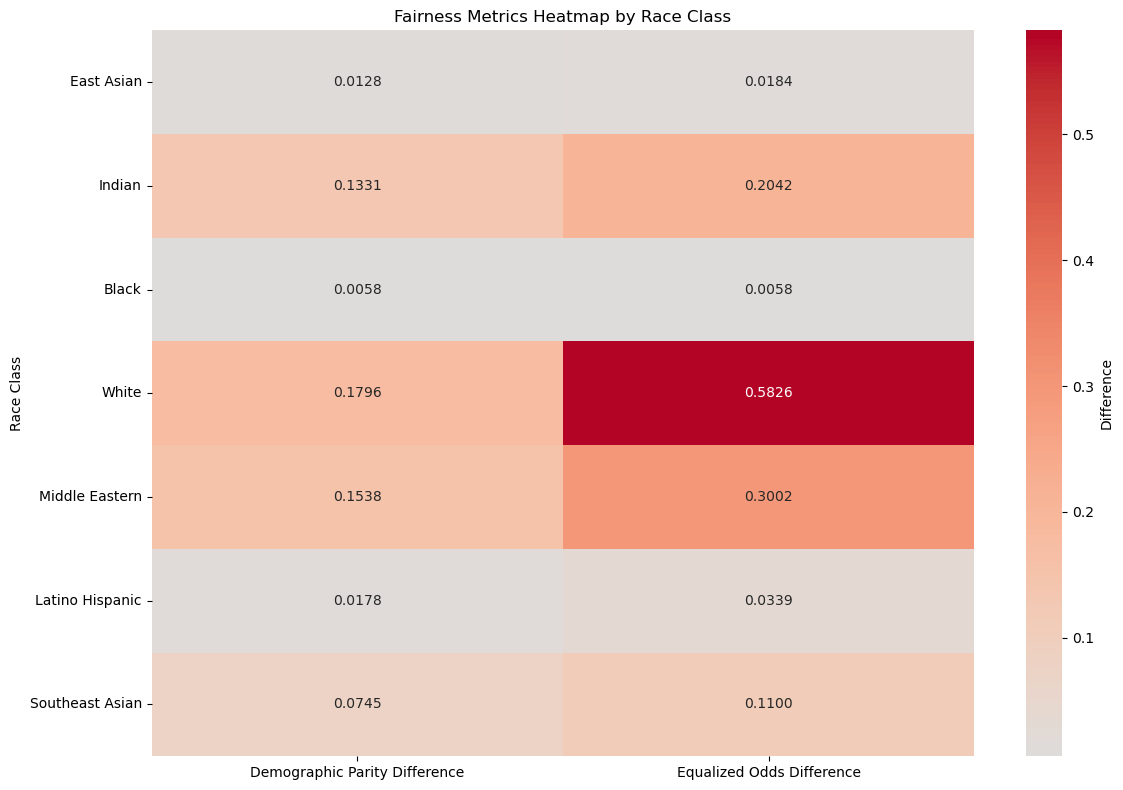

In [18]:
# Replace classes with race class labels using race_dict
classes = [race_dict[i] for i in range(len(race_dict))]

# Original data for demographic parity and equalized odds
demographic_parity = [0.0128, 0.1331, 0.0058, 0.1796, 0.1538, 0.0178, 0.0745]
equalized_odds = [0.0184, 0.2042, 0.0058, 0.5826, 0.3002, 0.0339, 0.1100]

# Prepare the data for the heatmap
data = {
    'Race Class': classes,
    'Demographic Parity Difference': demographic_parity,
    'Equalized Odds Difference': equalized_odds
}
df = pd.DataFrame(data)

# Set the Race Class as the index
df.set_index('Race Class', inplace=True)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Difference'}, fmt='.4f')
plt.title('Fairness Metrics Heatmap by Race Class')
plt.tight_layout()
plt.show()

C:\Users\noahw\AppData\Local\Temp\ipykernel_1804\86699927.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\noahw\AppData\Local\Temp\ipykernel_1804\86699927.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




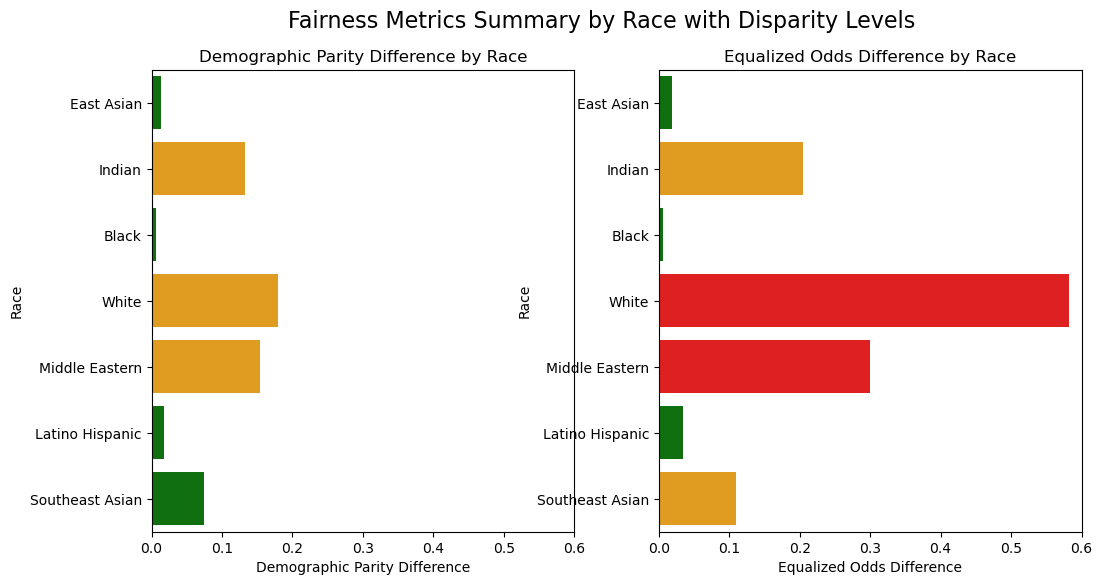

In [19]:
# Data for the groups and disparity values
data = {
    'Race': ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino Hispanic", "Southeast Asian"],
    'Demographic Parity Difference': [0.0128, 0.1331, 0.0058, 0.1796, 0.1538, 0.0178, 0.0745],
    'Equalized Odds Difference': [0.0184, 0.2042, 0.0058, 0.5826, 0.3002, 0.0339, 0.1100]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Determine colors for each disparity level
def get_color(value, metric):
    if value < 0.1:
        return 'green'   # Low disparity
    elif value < 0.30:
        return 'orange'  # Moderate disparity
    else:
        return 'red'     # High disparity

# Apply colors for both metrics
df['DP Color'] = df['Demographic Parity Difference'].apply(lambda x: get_color(x, 'Demographic Parity Difference'))
df['EO Color'] = df['Equalized Odds Difference'].apply(lambda x: get_color(x, 'Equalized Odds Difference'))

# Convert color columns to lists
dp_colors = df['DP Color'].tolist()
eo_colors = df['EO Color'].tolist()

# Plotting the bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Demographic Parity Difference
sns.barplot(x='Demographic Parity Difference', y='Race', data=df,
            palette=dp_colors, ax=ax[0])
ax[0].set_title("Demographic Parity Difference by Race")
ax[0].set_xlim(0, 0.6)

# Equalized Odds Difference
sns.barplot(x='Equalized Odds Difference', y='Race', data=df,
            palette=eo_colors, ax=ax[1])
ax[1].set_title("Equalized Odds Difference by Race")
ax[1].set_xlim(0, 0.6)

# Adding findings as text labels
fig.suptitle("Fairness Metrics Summary by Race with Disparity Levels", fontsize=16)
plt.show()

### Interpretation of Results

<!-- *Overall Accuracy:*

The overall accuracy of the model is 0.78 (78%). This indicates that the model correctly predicts the gender of individuals in the validation set about 78% of the time.
Selection Rate:

The overall selection rate is 0.487 (48.7%). This means that the model predicts the positive class (one race) about 48.7%% of the time across the entire validation set.
Accuracy by Sensitive Feature (Race):

The accuracy is fairly consistent across different racial groups (sensitive features 0 to 4), with values ranging from approximately 0.847 to 0.850. This suggests that the model performs similarly across different racial groups.
East Asian: Accuracy ~ 0.778
Indian: Accuracy ~ 0.777
Black: Accuracy ~ 0.771
White: Accuracy ~ 0.776
Middle Eastern: Accuracy ~ 0.780
Latino Hispanic: Accuracy ~ 0.781
Southeast Asian: Accuracy ~ 0.780

Selection Rate by Sensitive Feature (Race):

The selection rates vary across different racial groups, indicating that the model's propensity to predict the positive class differs by race.
East Asian: selection_rate ~ 0.534
Indian: selection_rate ~ 0.468
Black: selection_rate ~ 0.367
White: selection_rate ~ 0.439
Middle Eastern: selection_rate ~ 0.354
Latino Hispanic: selection_rate ~ 0.481
Southeast Asian: selection_rate ~ 0.517

Fairness Metrics:
Demographic Parity Difference: 0.179
This metric measures the difference in selection rates between the most and least favored groups. A value of 0.179 indicates that there is a 17.9% difference in the selection rates between the racial groups with the highest and lowest selection rates. This suggests some level of disparity in how the model treats different racial groups.
Equalized Odds Difference: 0.215
This metric measures the difference in true positive rates and false positive rates between the most and least favored groups. A value of 0.215 indicates that there is a 21.5% difference in the error rates between the racial groups with the highest and lowest error rates. This suggests some level of disparity in the model's performance across different racial groups.
Conclusion
Model Performance: The model performs well overall with an accuracy of approximately 78.0%
Fairness Concerns: There are some disparities in selection rates and error rates across different racial groups, as indicated by the demographic parity difference and equalized odds difference. These disparities suggest that the model may exhibit some bias towards certain racial groups. -->

### 3.1 Reflect on these questions while completing this stage


- Have i noticed anything odd?

- Which Sensitive Features were chosen for the model and why?

I will focus on ethnicity because this is a very important bias from a dataset and ethical standpoint
- Are the results in accordings with my initial assumptions?
NO, i expected Fairface to be more fair
- Can the analysis be improved? Is there anything that could be changed about the model?
The models implemented in this research serve as baseline tools to measure biases in facial age estimation datasets, prioritizing transparency in predictions over real-world optimization. Full optimization, including hyperparameter tuning, could improve performance but may reduce explainability and consistency, especially in cross-dataset analyses. 

This study has documented specific age, race and gender biases, but future work could delve deeper into subgroup biases by further dividing racial categories into smaller demographic groups. 
- Are there any suspected hidden biases that this analysis cannot capture?
- What resources were used to complete this stage?

https://fairlearn.org/ 
https://arxiv.org/pdf/1512.03385 
- Are there any ethical considerations at this stage?
it is problematic that the model performs so badly on specific races, white is very poor and middle eastern is alot a bit elevated
